# PiShield for learning shapes with requirements 

**Problem**: Hierarchical Multi-label Classification problem, where the labels are organised in a hierarchical structure.

**Example of a simple constraint from a functional genomics application**: 
if a protein belongs to the functional category bionsynthesis of glutamine, then it also belongs to amino acid metabolism functional category.

Let Class A be *bionsynthesis of glutamine* and Class B be *amino acid metabolism*.
Then the requirement can be written as: Class A &rarr; Class B. 

In [1]:
import sys
import time
from matplotlib.colors import ListedColormap
sys.path.append('..')
import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from plotting import plotting_experiment_results_net
from shapes import Rectangle, ShapeDataset

from pishield.shield_layer import build_shield_layer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(2)

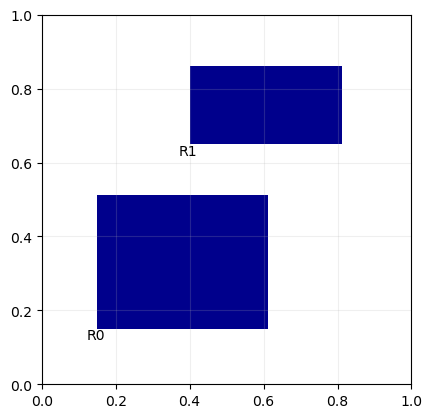

In [2]:
rectangle0 = Rectangle(0.15, 0.6, 0.15, 0.5)
rectangle1 = Rectangle(0.4, 0.8, 0.65, 0.85)
shapes = [rectangle0, rectangle1]

fig, ax = plt.subplots(1, 1)
ax.grid(alpha=0.2)

rgb = mpl.colormaps['seismic_r'](np.linspace(0.0, 1.0, 100))[np.newaxis, :, :3]
for i, shape in enumerate(shapes):
  shape.plot(ax, full=True, cmap=ListedColormap(rgb[0][-10:-9]))
  ax.annotate(f'R{i}', [z-0.029 for z in shape.get_left_low_corner()])
plt.show()

## Task Description
This notebook shows how to use [PiShield](https://github.com/mihaela-stoian/PiShield) for a hierarchical multi-label classification problem, where two rectangles R0 and R1 are used to define two different classes:
  - Class A is R0,
   - Class B is the union of R0 and R1.

**Task**: train a neural network to classify each point in a 1-by-1 grid by their position such that if they fall into rectangle R0, they are assigned both class A and class B, and if they fall into rectangle R1 here, they should be assigned class B.
     
**Training Data**: 2500 points, identified by their (x,y) coordinates, and their associated sets of classes.

**Requirement**: Class A &rarr; Class B. 

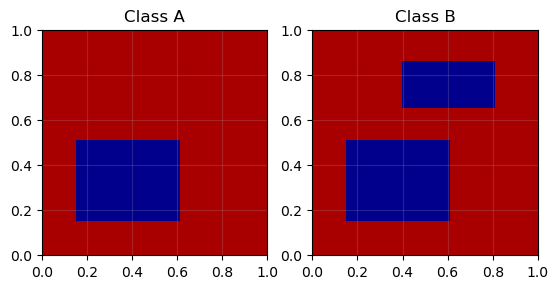

In [3]:
combined = rectangle0 | rectangle1
shapes = [rectangle0, combined]

fig, ax = plt.subplots(1, len(shapes))
ax[0].set_title("Class A")
ax[1].set_title("Class B")
ax[0].grid(alpha=0.2)
ax[1].grid(alpha=0.2)

rgb = mpl.colormaps['seismic_r'](np.linspace(0.0, 1.0, 100))[np.newaxis, :, :3]
for i, shape in enumerate(shapes):
  shape.plot(ax[i], full=True, cmap=ListedColormap(rgb[0][-10:-9]))
c1 = rgb[0][8]
ax[0].set_facecolor(c1)
ax[1].set_facecolor(c1)
plt.show()

## Define the requirements

If the classes are ordered as (Class A, Class B), and if the requirement is Class A &rarr; Class B, then it can be expressed in conjunctive normal form as follows, to be recognised by PiShield:

not y_0 or y_1

In [4]:
requirements_path = '../constraints/rectangles'

! cat $requirements_path

not y_0 or y_1

## Define the neural network

In [5]:
class PiShield_NeuralNetwork(torch.nn.Module):
    def __init__(self, shapes, requirements_path, points=2500, batch_size=2500, learning_rate=1e-1, hidden_dim=20):
        super(PiShield_NeuralNetwork, self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 2),
            nn.Sigmoid()
        )
        
        self.prepare_dataloaders(shapes, points, batch_size)
        self.loss_fn = nn.BCELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, betas = (0.9, 0.999))
        
        self.clayer = build_shield_layer(len(shapes), requirements_path, ordering_choice=None)
        
    def prepare_dataloaders(self, shapes, points, batch_size):
        train_data = ShapeDataset(shapes, points)
        test_data = ShapeDataset(shapes, points)
        self.train_dataloader = DataLoader(train_data, batch_size=batch_size)
        self.test_dataloader = DataLoader(test_data, batch_size=batch_size)
        
        
    def get_unconstrained_output(self, input):
        pred = self.linear(input)
        return pred
    
    def forward(self, input, goal=None):
        pred = self.linear(input)
        corrected_x = self.clayer(pred, goal=goal)
        return corrected_x

    def run(self, epochs):
        self.train()
        for epoch in range(epochs):
            for batch, (X, y) in enumerate(self.train_dataloader):
    
                # Compute prediction error
                pred = self(X, goal=y)
                loss = self.loss_fn(pred, y)
    
                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
    
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, loss: {loss.item():>7f} [{epoch:>5d}/{epochs:>5d}]")

    def save(self, dir='./models/'):
        path = f"{dir + 'rectangles'}-{int(time.time())}"
        torch.save(self, path + ".pth")
        print('Saved experiment at {path}'.format(path=path))

## Train and test the model

In [ ]:
model = PiShield_NeuralNetwork(shapes, requirements_path)
model.run(epochs=400)
model.save()
plotting_experiment_results_net(model, model.clayer, rectangle0, rectangle1)
plt.show()

Using auto mode ::: Detected propositional requirements!
[] [<pishield.propositional_requirements.constraint.Constraint object at 0x7f7b0dabcc90>]
head 1 with old rules 1
head 1 with new rules 1
Generated 1 strata of constraints with None centrality
Epoch 0, loss: 0.689555 [    0/  400]
Epoch 100, loss: 0.224294 [  100/  400]


In [ ]:
model = torch.load('./models/rectangles-1707355817.pth')  # model trained for 5000 epochs
plotting_experiment_results_net(model, model.clayer, rectangle0, rectangle1)
plt.show()